<a href="https://colab.research.google.com/github/Omaam/gcl/blob/main/gcl/20210915_TimelagSimulation_Hardlag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install and functions

In [1]:
!pip install stingray

     |████████████████████████████████| 29.4 MB 40 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for stingray: filename=stingray-0.3-py3-none-any.whl size=29100134 sha256=1d09893c6aebd80ace52274983d4596456ebad298eddf85fc4e601bd73c4d29a
  Stored in directory: /root/.cache/pip/wheels/b6/c6/9b/11cc438f1195c1c60fc134bda652cd01df3b75b3a9b426754a
Successfully built stingray


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import zscore
import stingray as stgr
from stingray.simulator import simulator
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum

sns.set(style='whitegrid', context='talk')

dpi = 150
figsize = (11, 7)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "
/usr/local/lib/python3.7/dist-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/usr/local/lib/python3.7/dist-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/usr/local/lib/python3.7/dist-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. U

In [3]:
def ccf(x, y, fs=1, maxlags=None):
    x = (x-np.mean(x)) / np.std(x)
    y = (y-np.mean(y)) / np.std(y)

    # calcurate correlation and lags
    n_x, n_y = len(x), len(y)
    r = signal.correlate(y, x, mode='full')
    r = r / (np.sqrt(n_x)*np.std(x)) / (np.sqrt(n_y)*np.std(y))
    lags = np.arange(-n_x + 1, n_y) / fs

    # query
    T = max(n_x, n_y)
    maxlags = 2 * T - 1 if maxlags is None else maxlags
    lag_out = lags[((-maxlags <= lags) & (lags <= maxlags))]
    r_out = r[((-maxlags <= lags) & (lags <= maxlags))]

    return lag_out, r_out

In [4]:
def symccf(a, base_side='left'):

    # make array
    corr_sym = np.copy(a) if base_side == 'left' else np.copy(a[::-1])

    # get center index + 1
    idx_med_m2 = int(np.floor(len(corr_sym)/2)) - 1
    idx_med_p1 = int(np.ceil(len(corr_sym)/2))

    # substitute
    corr_sym[idx_med_p1:] = corr_sym[idx_med_m2::-1]

    # substraction
    out = a - corr_sym

    return out

## main sequence

In [5]:
# make lightcurves
N = 2**7
lag = 2**2
dt = 1
sim = simulator.Simulator(N=N, mean=1., rms=0.2, dt=dt, random_state=20210913)
base = sim.simulate(2)
diskbb = base[lag:N]
pow = base[0:N-lag]

/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


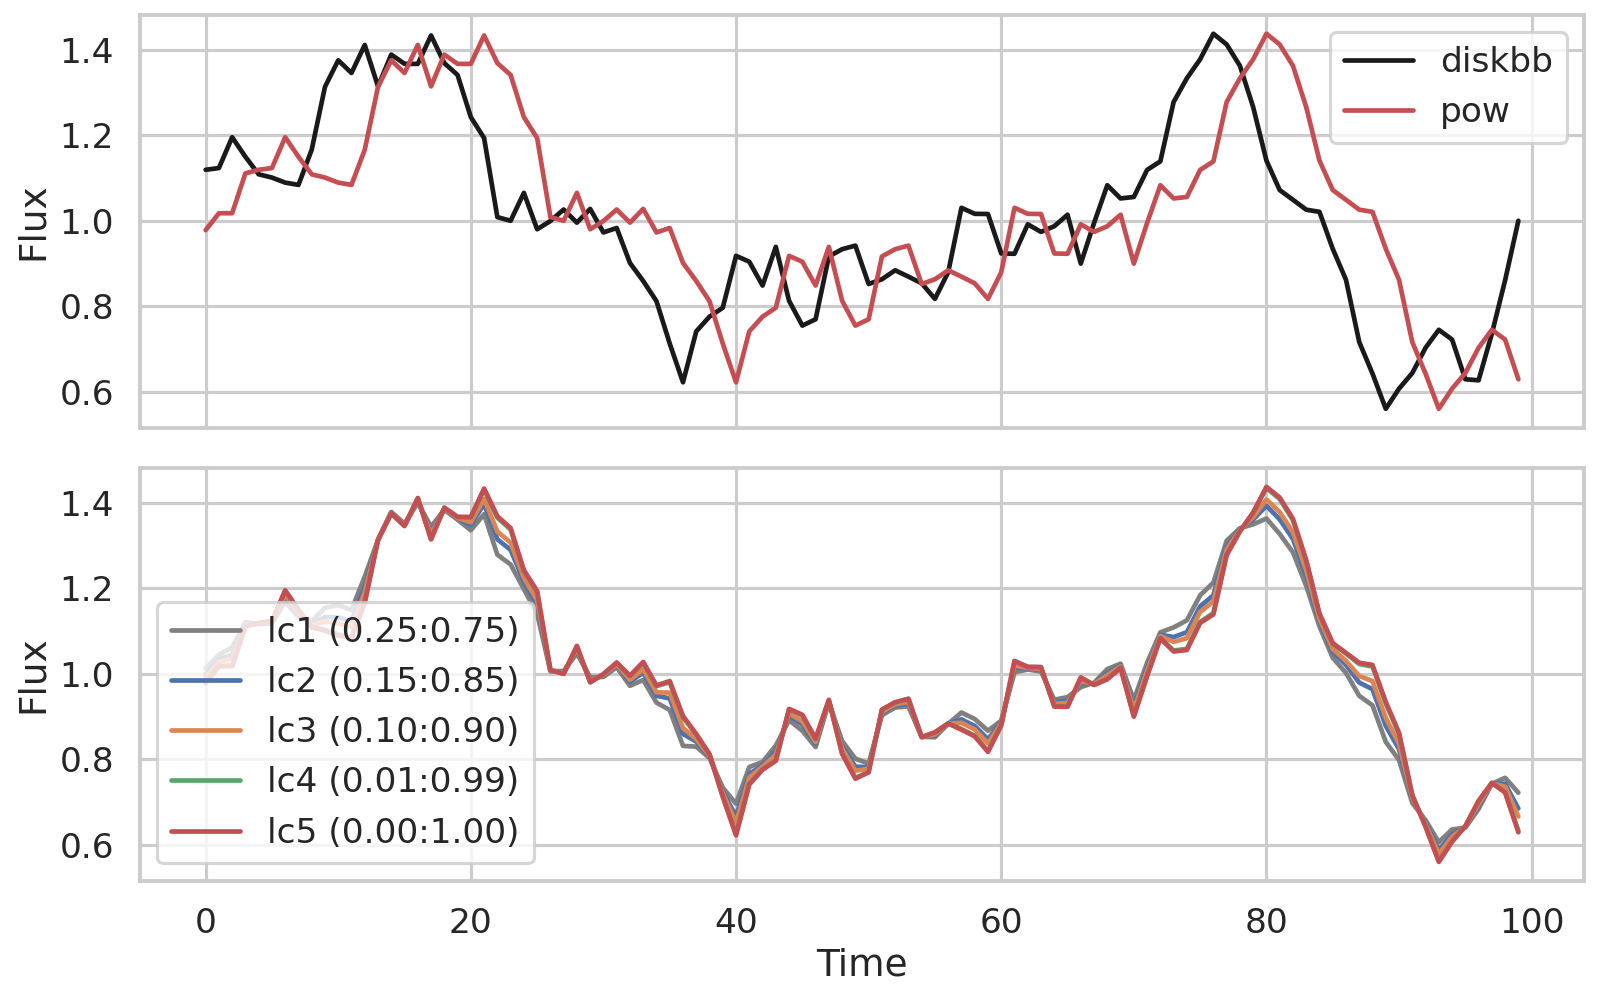

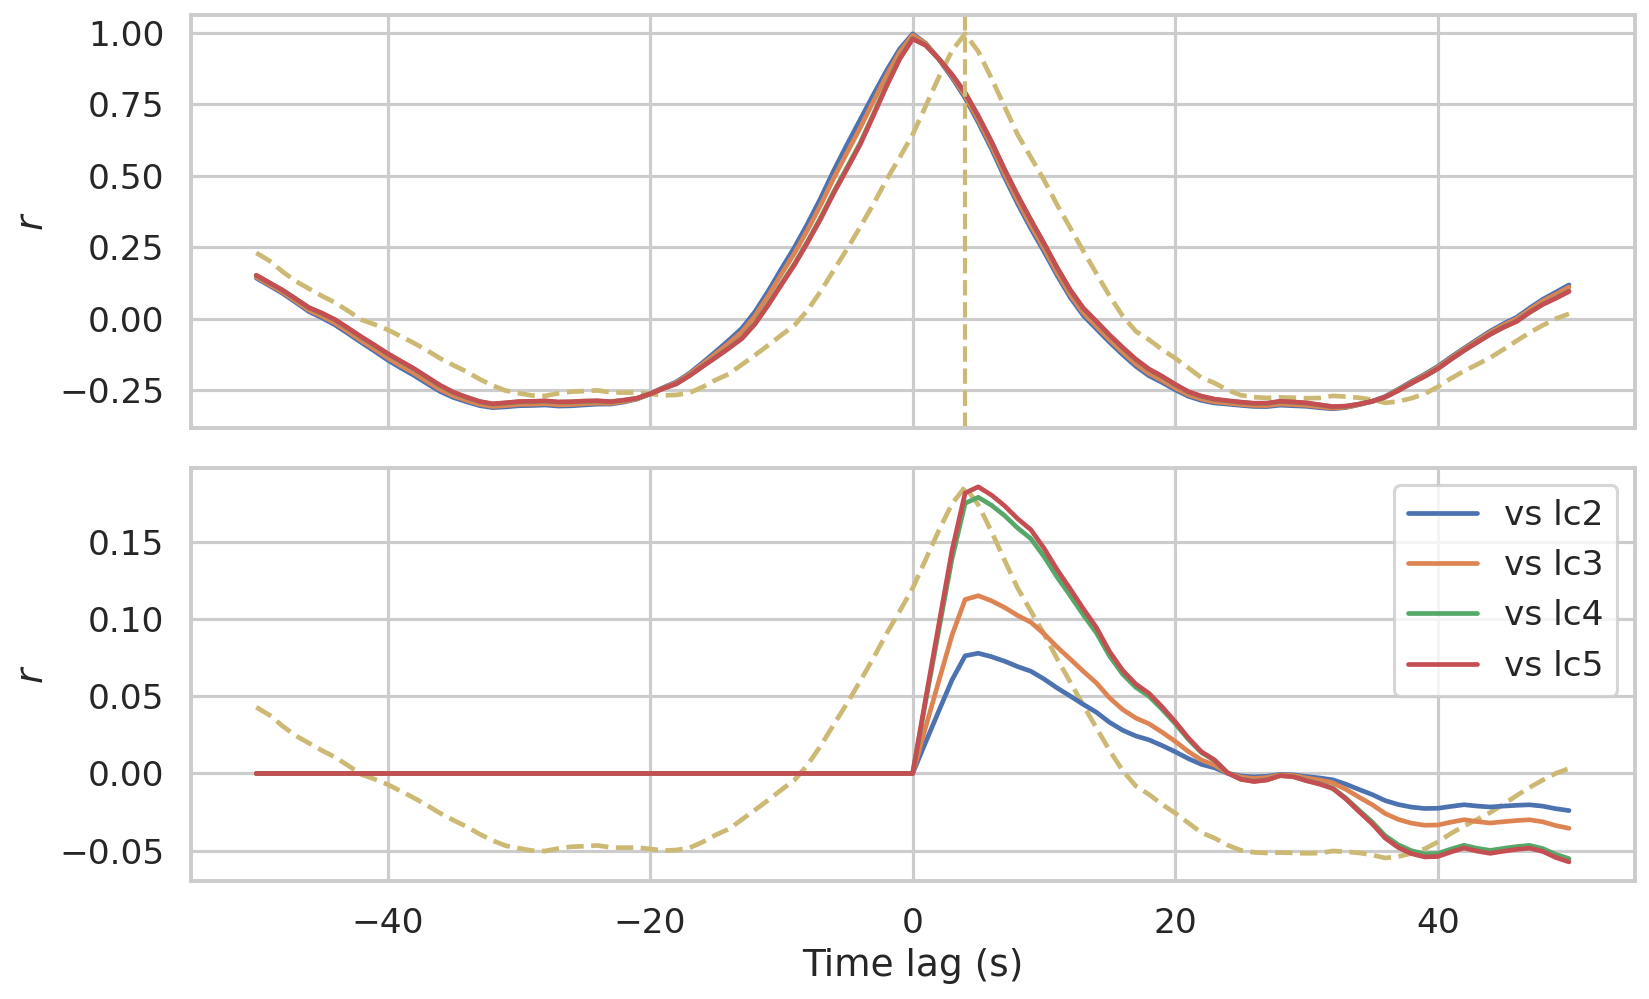

In [6]:
# lightcurves
A = [[0.25, 0.75],
      [0.15, 0.85],
      [0.10, 0.90],
      [0.01, 0.99],
      [0.00, 1.00]]
xs = np.array([diskbb, pow])
lc_list = np.dot(A, xs)
lc1, lc2, lc3, lc4, lc5 = lc_list
time = np.arange(len(lc1))
lc1 = Lightcurve(time, lc1, skip_checks=True, dt=dt)
lc2 = Lightcurve(time, lc2, skip_checks=True, dt=dt)
lc3 = Lightcurve(time, lc3, skip_checks=True, dt=dt)
lc4 = Lightcurve(time, lc4, skip_checks=True, dt=dt)
lc5 = Lightcurve(time, lc5, skip_checks=True, dt=dt)

# figure: plot summationed lightcurves
fig, ax = plt.subplots(2, sharex=True, dpi=dpi, figsize=figsize)
idx_start = 0
idx_end = 100
ax[0].plot(time[idx_start:idx_end], diskbb.counts[idx_start:idx_end], c='k', label='diskbb')
ax[0].plot(time[idx_start:idx_end], pow.counts[idx_start:idx_end], c='r', label='pow')
ax[0].set_ylabel('Flux')
ax[0].legend(loc='best')

ax[1].plot(time[idx_start:idx_end], lc1[idx_start:idx_end], label='lc1 (0.25:0.75)', color='grey')
ax[1].plot(time[idx_start:idx_end], lc2[idx_start:idx_end], label='lc2 (0.15:0.85)')
ax[1].plot(time[idx_start:idx_end], lc3[idx_start:idx_end], label='lc3 (0.10:0.90)')
ax[1].plot(time[idx_start:idx_end], lc4[idx_start:idx_end], label='lc4 (0.01:0.99)')
ax[1].plot(time[idx_start:idx_end], lc5[idx_start:idx_end], label='lc5 (0.00:1.00)')
ax[1].legend(loc='best')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Flux')

plt.tight_layout()
plt.show()

# calcurate CCF
lags, r12 = ccf(lc1.counts, lc2.counts, fs=1, maxlags=50)
lags, r13 = ccf(lc1.counts, lc3.counts, fs=1, maxlags=50)
lags, r14 = ccf(lc1.counts, lc4.counts, fs=1, maxlags=50)
lags, r15 = ccf(lc1.counts, lc5.counts, fs=1, maxlags=50)
r12_sym = symccf(r12)
r13_sym = symccf(r13)
r14_sym = symccf(r14)
r15_sym = symccf(r15)

# diskbb vs pow
lags, r_od = ccf(diskbb.counts, pow.counts, fs=1, maxlags=50)
idx_del = np.argmax(r_od)

# figure: CCF
fig, ax = plt.subplots(2, sharex=True, dpi=dpi, figsize=figsize)
ax[0].plot(lags, r_od, color='y', ls='--')
ax[0].plot(lags, r12)
ax[0].plot(lags, r13)
ax[0].plot(lags, r14)
ax[0].plot(lags, r15)
ax[0].axvline(lags[idx_del], c='y', ls='--', lw=2)
ax[0].set_ylabel(r'$r$')

ax[1].plot(lags, (r_od/r_od.max())*r15_sym.max(), color="y", ls="--")
ax[1].plot(lags, r12_sym, label='vs lc2')
ax[1].plot(lags, r13_sym, label='vs lc3')
ax[1].plot(lags, r14_sym, label='vs lc4')
ax[1].plot(lags, r15_sym, label='vs lc5')
ax[1].legend(loc='best')
# ax[1].axvline(4, c='y', ls='--', lw=2)
ax[1].set_xlabel('Time lag (s)')
ax[1].set_ylabel(r'$r$')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 46.33it/s]
/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 263.25it/s]
/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
3it [00:00, 262.31it/s]
/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Number of segments used in averaging is significantly low. The result might not follow the expected statistical distributions.
  wa

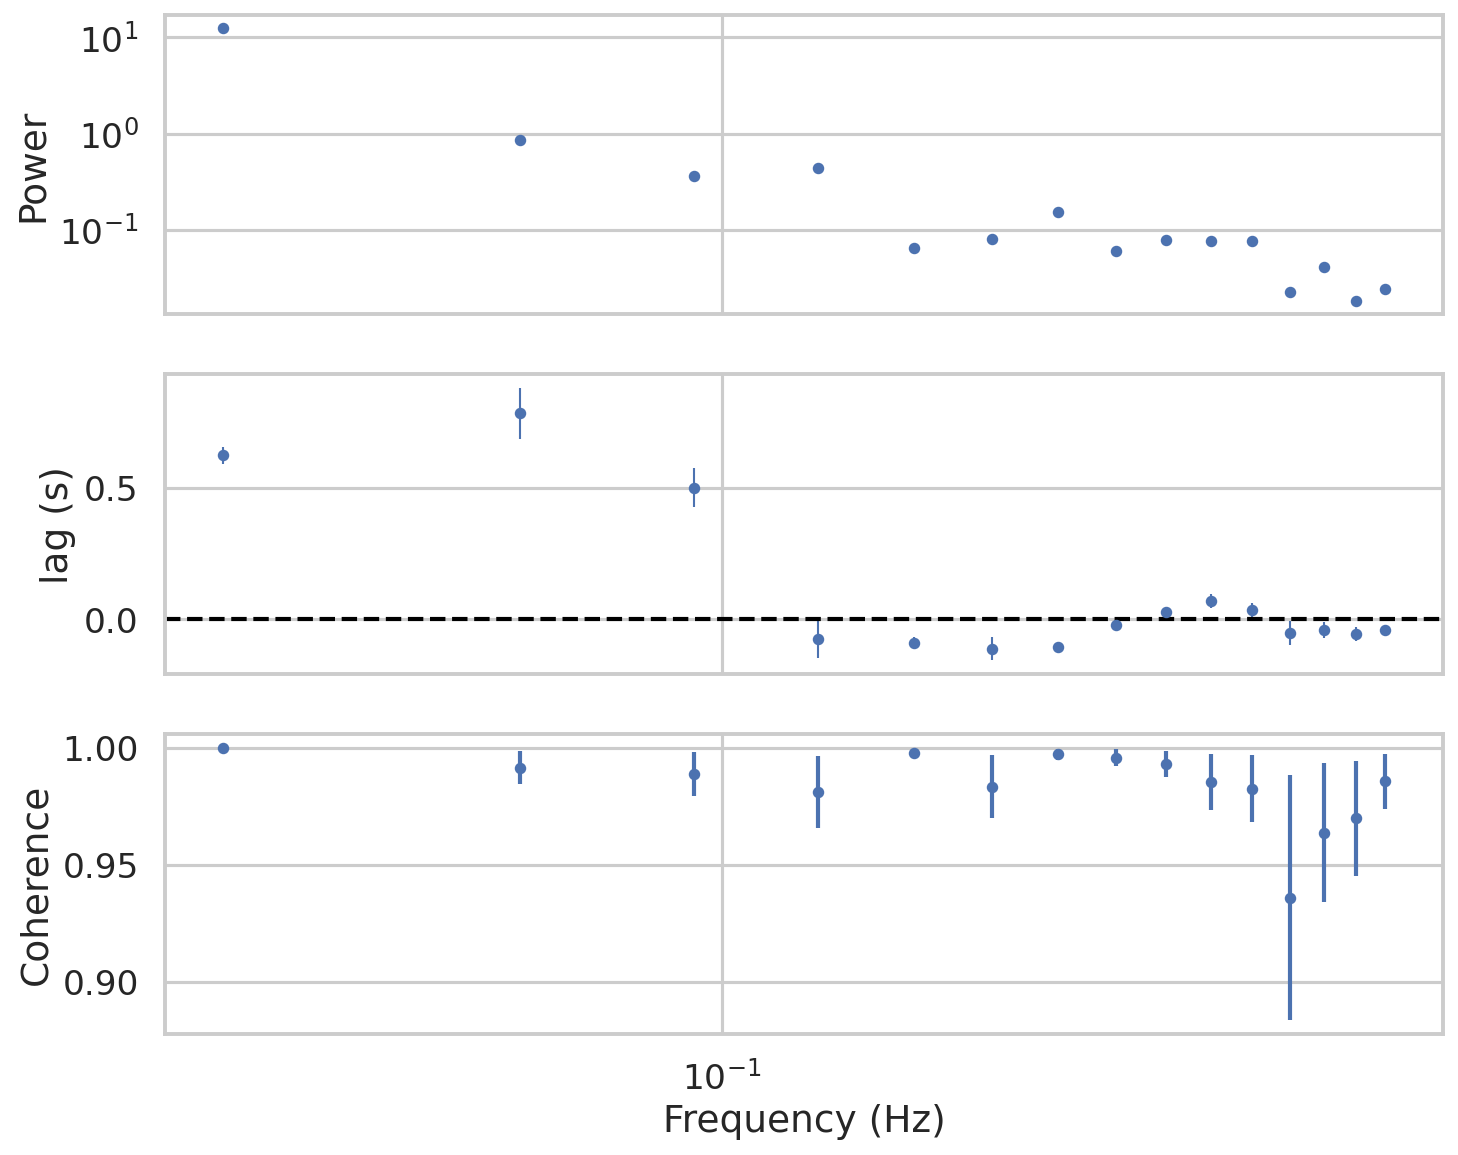

In [7]:
# lightcurves
A = [[1, 0],
      [0.8, 0.2]]
xs = np.array([diskbb, pow])
lc1, lc2 = np.dot(A, xs)
time = np.arange(len(lc1))
lc1 = Lightcurve(time, lc1, skip_checks=True, dt=dt)
lc2 = Lightcurve(time, lc2, skip_checks=True, dt=dt)

# Crosss-spectrum analysis
avg_cs = AveragedCrossspectrum(lc1, lc2, N/2**2)
freq_lags, freq_lags_err = avg_cs.time_lag()

# figure: errorbar
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(11, 9), dpi=dpi)

# power
ax[0].errorbar(avg_cs.freq, avg_cs.power, lw=2, fmt='.')
ax[0].set_yscale('log')
ax[0].set_ylabel("Power")

# time lag
ax[1].axhline(0, color='black', linestyle='dashed', lw=2)
# ax[1].axhline(4, color='r', linestyle='dashed', lw=2)
ax[1].errorbar(avg_cs.freq, freq_lags, yerr=freq_lags_err, fmt=".", lw=1)
ax[1].set_ylabel("lag (s)")

# coherence
coh, err_coh = avg_cs.coherence()
ax[2].errorbar(avg_cs.freq, coh, yerr=err_coh, lw=2, fmt='.')
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Coherence")
ax[2].set_xscale('log')

plt.show()